Robot Dynamics Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [ ]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
import pickle
import os.path
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Folder dir for saving and loading files

In [2]:
model_folder = 'data/model/'
trajectory_folder = 'data/trajectory/'
optimal_trajectory_folder = 'data/optimal_trajectory/'

---
# 2 - Robot modelling

## Create joint variables and define their relations

In [3]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9 = new_sym('q:10')
# define paralelogram coordinate relation
# q3 = -q2 + q8
# q9 = -q8 + q2

## Robot geometry definition in following order

| Joint number | previous link | successive links | $a$ | $\alpha$ | $d$ | $\theta$ |
|--------------|---------------|------------------|-----|----------|-----|----------|

In [20]:
#robot_def = RobotDef([(0,   -1, [1],    0,      0,              0,          0),
#                      (1,   0,  [2],    0,      0,              -0.21537,   q1),
#                      (2,   1,  [3],    0,      -sympy.pi/2,    0,          q2+sympy.pi/2),
#                      (3,   2,  [4],    0.279,  0,              0,          q3 + sympy.pi / 2)],
#                     dh_convention='mdh',
#                     friction_type=['Coulomb', 'viscous', 'offset'])

robot_def = RobotDef([(0,   -1, [1],    0,      0,              0,          0),
                      (1,   0,  [2],    0,      0,              -0.21537,   q1),
                      (2,   1,  [3],    0,      -sympy.pi/2,    0,          q2+sympy.pi/2),
                      (3,   2,  [4],    0.279,  0,              0,          q3 + sympy.pi / 2)],
                     dh_convention='mdh',
                     friction_type=['Coulomb', 'viscous', 'offset'])

In [21]:
robot_def.coordinates

In [22]:
robot_def.std_params

In [23]:
robot_def.bary_params

## Create kinematics chain

In [24]:
geom = Geometry(robot_def)


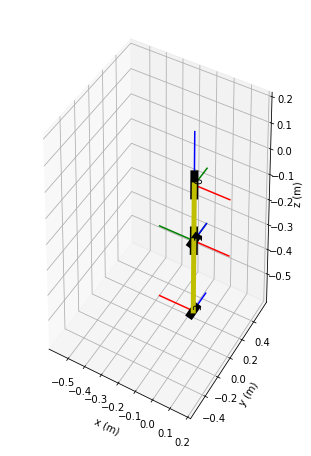

In [25]:
geom.draw_geom()

In [29]:
geom.T_0nc[1]

⎡                      l1x⋅cos(q₁)   l1y⋅sin(q₁)⎤
⎢cos(q₁)  -sin(q₁)  0  ─────────── - ───────────⎥
⎢                           m₁            m₁    ⎥
⎢                                               ⎥
⎢                      l1x⋅sin(q₁)   l1y⋅cos(q₁)⎥
⎢sin(q₁)  cos(q₁)   0  ─────────── + ───────────⎥
⎢                           m₁            m₁    ⎥
⎢                                               ⎥
⎢                            l1z                ⎥
⎢   0        0      1        ─── - 0.21537      ⎥
⎢                             m₁                ⎥
⎢                                               ⎥
⎣   0        0      0              1            ⎦

## Create dynamics object


In [34]:
%time dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating joint torques...
Calculating gregressor...
Calculating M, C and G...
Calculating base parameter...
CPU times: user 2min 3s, sys: 296 ms, total: 2min 4s
Wall time: 2min 3s


In [48]:
sympy.Matrix([robot_def.dh_theta[1]]).free_symbols

---
# 3 - Excitation trajectory optimization

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [38]:
base_freq = 0.1
fourier_order = 6

traj_optimizer = TrajOptimizer(dyn, fourier_order, base_freq,
                               joint_constraints=[(q1, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                                                  (q2, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi)])
traj_optimizer.optimize()

joint constraint number: 2
cartisian constraint number: 0
constraint number: 8
Condition number: 3.20650548482
x: [-0.11528272  0.25268749  0.05992388  0.94772332  1.         -1.
 -1.          0.42657318 -0.81330974  0.95300056  0.51798483  1.
  1.          0.49894273 -0.30670539  1.          0.1160871  -0.15542272
  1.          1.         -0.30651719  0.72343516  0.54411519  1.
 -0.50518016  1.         -1.42332592 -0.02660107 -0.23065943 -0.89198502
 -1.         -0.95487182 -1.          1.         -0.90522326 -0.62637916
  1.          0.89595431 -1.        ]

SLSQP Solution to Optimial Excitation Trajectory

        Objective Function: _obj_func

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                    9.3462
    Total Function Evaluations:          
    Sensitivities:        FD

    Objectives:
        Name        Value        Optimum
	     f         3.20651             0

	Variables (c - continuous, i - intege

## Plot optimal excitation trajectory

('traj:', 0)
('traj:', 1)
('traj:', 2)


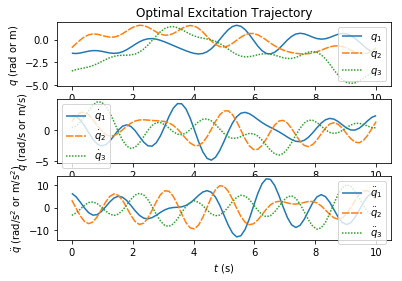

In [10]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

## Save trajectory for later use

In [11]:
dof_order_bf_x = (traj_optimizer.fourier_traj.dof, fourier_order, base_freq, traj_optimizer.x_result)


In [12]:
dof_order_bf_x_file_name = 'optimal_traj1.pkl'
dof_order_bf_x_dir = optimal_trajectory_folder + dof_order_bf_x_file_name

#if not os.path.exists(dof_order_bf_x_dir):
with open(dof_order_bf_x_dir, 'wr') as f:
    pickle.dump(dyn.H_b, f)

---
# Data processing

In [13]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

## Load data

In [14]:
trajectory_data_file = trajectory_folder + 'test.csv'
trajectory_sampling_rate = 200
t, q_raw, tau_raw = load_trajectory_data(trajectory_data_file, trajectory_sampling_rate)
dof = q_raw.shape[1]

(<type 'numpy.ndarray'>, (6000, 6))


## Calculate filter cut-off frequency

In [15]:
fc_mult = 10.0
wf = 0.1
order = 5
fc = wf * order * fc_mult
print("cut frequency is {}".format(fc))

cut frequency is 5.0


## Get velocity and acceleration data and filter raw data

q_raw shape: (6000, 3)
0
1
2
plot shape: 430


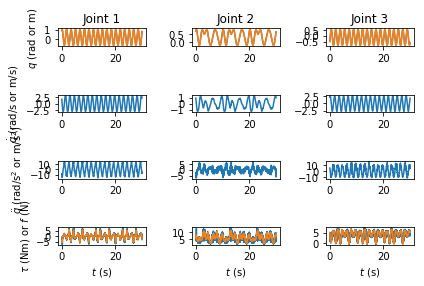

In [16]:
t_cut, q_f, dq_f, ddq_f, tau_f, q_raw_cut, tau_raw_cut = diff_and_filt_data(dof, 1.0/trajectory_sampling_rate, t,
                                                                        q_raw, tau_raw, fc, fc, fc, fc)
plot_trajectory_data(t_cut, q_raw_cut, q_f, dq_f, ddq_f, tau_raw_cut, tau_f)

In [17]:
traj_optimizer.x_result

array([-0.43088801, -0.32401528, -0.30853451, -0.99926804,  0.95415126,
       -0.99991612,  1.        ,  0.15189284,  0.19847208,  0.89909112,
       -1.        ,  0.99158857,  1.        , -0.07347386,  0.69439051,
        0.26310269, -0.19824484,  0.3297264 ,  0.78312463,  0.99999996,
        0.2457836 ,  0.14011726, -0.07901393,  0.99990202, -1.        ,
        1.        , -1.64018449,  0.66495307, -0.4888334 ,  0.97452591,
        0.99998095,  0.1335359 , -1.        ,  1.        ,  0.89461609,
       -0.26008492, -0.02720468, -0.28667669, -1.        ])

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [18]:
base_param_num = dyn.base_num
H_b_func = dyn.H_b_func
W_b, tau_s = gen_regressor(base_param_num, H_b_func, q_f, dq_f, ddq_f, tau_f)

In [19]:
print(W_b.shape, tau_s.shape)

((17970, 15), (17970,))


In [20]:
xb_ols = np.linalg.lstsq(W_b, tau_s)[0]

/home/yan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [21]:
xb_ols

array([ 4.51759594e-01, -5.50129960e-04,  7.21406441e-02, -2.03789196e-02,
        7.79418804e-04,  8.39004192e-01,  1.42708260e-02,  3.04222130e-03,
        1.04918787e-01,  1.21380433e-04, -9.80113090e-04,  1.30898057e-01,
        4.97529618e-02,  1.79097965e-01,  3.10781502e-01])

## Compare measured torque and predicted torque

### Generate predicted torque

In [22]:
tau_p = np.zeros(tau_f.shape)
tau_ps = W_b.dot(xb_ols)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof]

### Evaluate regression

In [23]:
var_regression_error_ols = np.linalg.norm(tau_ps - tau_s) / (tau_ps.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols * np.linalg.inv(W_b.transpose().dot(W_b))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.0022718597256644974
standard deviation of xb using OLS:
[8.17399761e-05 7.93194379e-05 2.06990051e-04 7.55993668e-05
 6.13950613e-05 3.92365726e-04 1.66379760e-04 1.63771907e-04
 1.70608326e-04 2.14751179e-04 1.21574894e-04 1.22162924e-04
 1.61095358e-04 4.73460573e-04 4.06769460e-04]
percentage of standard deviation of xb using OLS: 
[1.80936890e-04 1.44183091e-01 2.86925703e-03 3.70968472e-03
 7.87703106e-02 4.67656454e-04 1.16587337e-02 5.38330027e-02
 1.62609892e-03 1.76924050e+00 1.24041700e-01 9.33267662e-04
 3.23790487e-03 2.64358432e-03 1.30885994e-03]


### Plot measured torque and predicted torque

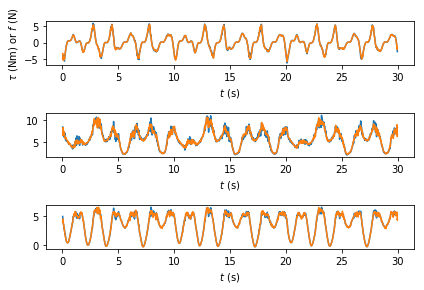

In [24]:
plot_meas_pred_tau(t_cut, tau_f, tau_p)

## Weighted Least Square (WLS)

In [25]:
robot_def.params

## Convex optimization

In [26]:
# #from identification import SDPOpt
# import cvxpy as cp

# # sdp_opt = SDPOpt(W_b, tau_s, None)
# # sdp_opt.solve()
# m, n = W_b.shape
# sdp_x = cp.Variable(n)
# sdp_obj = cp.Minimize(cp.sum_squares(W_b*sdp_x - tau_s))
# sdp_constraints = []
# sdp_prob = cp.Problem(sdp_obj, sdp_constraints)

# result = sdp_prob.solve(solver=cp.OSQP)

# print(sdp_x.value)

[ 4.51759594e-01 -5.50129960e-04  7.21406441e-02 -2.03789196e-02
  7.79418804e-04  8.39004192e-01  1.42708260e-02  3.04222130e-03
  1.04918787e-01  1.21380433e-04 -9.80113090e-04  1.30898057e-01
  4.97529618e-02  1.79097965e-01  3.10781502e-01]


In [27]:
# xb_ols

array([ 4.51759594e-01, -5.50129960e-04,  7.21406441e-02, -2.03789196e-02,
        7.79418804e-04,  8.39004192e-01,  1.42708260e-02,  3.04222130e-03,
        1.04918787e-01,  1.21380433e-04, -9.80113090e-04,  1.30898057e-01,
        4.97529618e-02,  1.79097965e-01,  3.10781502e-01])

### Generate regressor matrix for barycentric parameters

In [77]:
from identification import SDPOpt

std_param_num = len(robot_def.params)
H_func = dyn.H_func
W, tau_s = gen_regressor(std_param_num, H_func, q_f, dq_f, ddq_f, tau_f)

In [78]:
# constraint order: (min_m, max_m, min_x, max_x, min_y, max_y, min_z, max_z)
sdp_constraints = [(1, 10, -0.05, 0.05, 0, 0.1, 0, 0.2),
                  (0.5, 3, -0.1, 0.1, -0.1, 0.1, -0.05, 0.05),
                  (0.5, 5, 0, 0.3, 0, 0.1, -0.05, 0.05)]

In [79]:
sdp_opt_std = SDPOpt(W, tau_s, robot_def.params, robot_def.dof, sdp_constraints)
sdp_opt_std.solve()

Regressor shape: (17970, 30)
Regressand shape: (17970,)
Creating variables...
Creating optimization objective...
Creating constraints...
[ 6.93476694e+00 -5.15035491e-14  6.36217716e-18  5.55478691e+00
 -2.69482134e-06  9.33239228e-06 -8.99389276e-17  7.18681514e-09
  1.39591302e-08  3.19711706e+00  4.46961477e-02  8.26066599e-04
  5.82767934e-03  1.46088627e-01  2.12336301e-04  1.11681689e-01
  2.92234068e-01 -5.20542840e-04 -5.81210585e-02  2.99822334e+00
  4.81911557e-03 -2.06258707e-02 -1.35500894e-03  1.07771262e-01
  1.12091132e-03  1.22873801e-01  4.53185640e-01  8.26759042e-02
  2.02840778e-02  2.10997770e+00]


## Compare measured torque and predicted torque

### Generate predicted torque

In [80]:
tau_sdp_p = np.zeros(tau_f.shape)
tau_sdp_ps = W.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_sdp_p[:, i] = tau_sdp_ps[i::dof]

### Plot measured torque and predicted torque

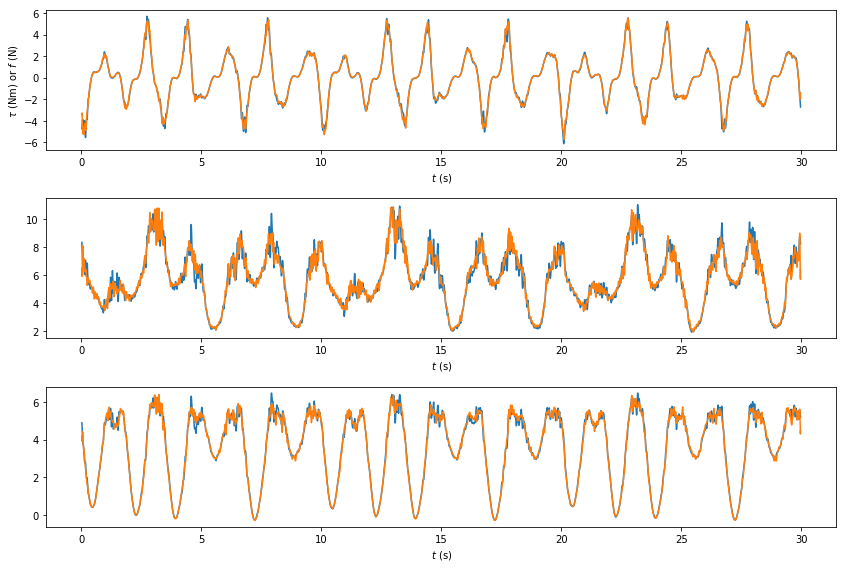

In [81]:
plot_meas_pred_tau(t_cut, tau_f, tau_sdp_p)

In [89]:
sympy.Matrix.hstack(sympy.Matrix(robot_def.params), sympy.Matrix(sdp_opt_std.x_result))

⎡L1xx    6.93476694440786   ⎤
⎢                           ⎥
⎢L1xy  -5.15035491219744e-14⎥
⎢                           ⎥
⎢L1xz  6.36217715962074e-18 ⎥
⎢                           ⎥
⎢L1yy    5.55478691001959   ⎥
⎢                           ⎥
⎢L1yz  -2.69482133504241e-6 ⎥
⎢                           ⎥
⎢L1zz   9.33239228412096e-6 ⎥
⎢                           ⎥
⎢l1x   -8.99389275993746e-17⎥
⎢                           ⎥
⎢l1y    7.18681513674972e-9 ⎥
⎢                           ⎥
⎢l1z    1.39591302400843e-8 ⎥
⎢                           ⎥
⎢ m₁     3.19711705900063   ⎥
⎢                           ⎥
⎢L2xx   0.0446961477391961  ⎥
⎢                           ⎥
⎢L2xy   0.00082606659873916 ⎥
⎢                           ⎥
⎢L2xz   0.00582767934044085 ⎥
⎢                           ⎥
⎢L2yy    0.146088627056155  ⎥
⎢                           ⎥
⎢L2yz  0.000212336300896343 ⎥
⎢                           ⎥
⎢L2zz    0.111681688930716  ⎥
⎢                           ⎥
⎢l2x     0.292234068345849  ⎥
⎢         

In [83]:
from identification import barycentric2standard_params

In [84]:
sdp_opt_std.x_result

array([ 6.93476694e+00, -5.15035491e-14,  6.36217716e-18,  5.55478691e+00,
       -2.69482134e-06,  9.33239228e-06, -8.99389276e-17,  7.18681514e-09,
        1.39591302e-08,  3.19711706e+00,  4.46961477e-02,  8.26066599e-04,
        5.82767934e-03,  1.46088627e-01,  2.12336301e-04,  1.11681689e-01,
        2.92234068e-01, -5.20542840e-04, -5.81210585e-02,  2.99822334e+00,
        4.81911557e-03, -2.06258707e-02, -1.35500894e-03,  1.07771262e-01,
        1.12091132e-03,  1.22873801e-01,  4.53185640e-01,  8.26759042e-02,
        2.02840778e-02,  2.10997770e+00])

In [85]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_def.params)

([6.93476694440786, -5.15035491221766e-14, 6.36217676693284e-18, 5.55478691001959, -2.69482133501103e-6, 9.33239228410481e-6], [-2.813125886216004e-17, 2.247904910618506e-09, 4.366161758383573e-09], 3.1971170590006337)
([0.0435693709710394, 0.000775329767422557, 0.000162673283973115, 0.116478155096301, 0.000222427110491160, 0.0831978129887420], [0.09746907924891887, -0.0001736170994839562, -0.019385166447340396], 2.9982233401377956)
([0.00138460109297596, -0.00286855855159073, 0.00300164980595019, 0.0102400568540123, 0.00191570856910424, 0.0222980797482639], [0.21478219440917587, 0.03918330710438234, 0.009613408631879546], 2.109977699714676)
